## Library

In [1]:
import os
import zipfile
import pandas as pd

import torch
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm

from PIL import Image
import cv2
import matplotlib.pyplot as plt 
import numpy as np 
from sklearn.model_selection import train_test_split

## kaggle

In [2]:
with open(".env") as f:
    for line in f:
        key, val = line.strip().split("=")
        os.environ[key] = val

# print("Kaggle user:", os.environ['KAGGLE_USERNAME'])  
# print("Kaggle user:", os.environ['KAGGLE_KEY'])  

In [ ]:
# !mkdir -p Data
# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p Data

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other




  0%|          | 0.00/2.29G [00:00<?, ?B/s]
  2%|‚ñè         | 48.0M/2.29G [00:00<00:04, 498MB/s]
  4%|‚ñç         | 100M/2.29G [00:00<00:04, 522MB/s] 
  6%|‚ñã         | 150M/2.29G [00:00<00:04, 492MB/s]
  9%|‚ñâ         | 211M/2.29G [00:00<00:04, 547MB/s]
 11%|‚ñà         | 264M/2.29G [00:00<00:05, 403MB/s]
 13%|‚ñà‚ñé        | 307M/2.29G [00:00<00:05, 360MB/s]
 15%|‚ñà‚ñç        | 346M/2.29G [00:00<00:05, 351MB/s]
 17%|‚ñà‚ñã        | 393M/2.29G [00:01<00:05, 386MB/s]
 19%|‚ñà‚ñä        | 435M/2.29G [00:01<00:05, 400MB/s]
 21%|‚ñà‚ñà        | 484M/2.29G [00:01<00:04, 431MB/s]
 22%|‚ñà‚ñà‚ñè       | 527M/2.29G [00:01<00:04, 415MB/s]
 24%|‚ñà‚ñà‚ñç       | 569M/2.29G [00:01<00:04, 421MB/s]
 26%|‚ñà‚ñà‚ñå       | 611M/2.29G [00:01<00:04, 390MB/s]
 28%|‚ñà‚ñà‚ñä       | 669M/2.29G [00:01<00:03, 448MB/s]
 31%|‚ñà‚ñà‚ñà       | 721M/2.29G [00:01<00:03, 475MB/s]
 33%|‚ñà‚ñà‚ñà‚ñé      | 768M/2.29G [00:01<00:03, 441MB/s]
 35%|‚ñà‚ñà‚ñà‚ñç      | 812M/2.29G [00:02<00:03, 413MB/s]
 36%|‚ñà‚ñ

In [ ]:
# with zipfile.ZipFile("Data/chest-xray-pneumonia.zip", "r") as zip_ref:
#     zip_ref.extractall("Data/")

## Data preparation

**1) Pull data from folder** 

In [4]:
def make_dataframe(base_dir):
    filepaths = []
    labels = []

    for split in ["train", "val", "test"]:
        for label_dir in ["NORMAL", "PNEUMONIA"]:
            path = os.path.join(base_dir, split, label_dir)
            for filename in os.listdir(path):
                filepaths.append(os.path.join(path, filename))
                labels.append(0 if label_dir == "NORMAL" else 1)

    df = pd.DataFrame({
        "filepath": filepaths,
        "label": labels
    })
    return df

base_dir = "Data/chest_xray" # Your path -------------------------------------------------------------
df_all = make_dataframe(base_dir)
print(len(df_all))
df_all['label'].value_counts()

5856


label
1    4273
0    1583
Name: count, dtype: int64

**2) Image size**

‡∏ó‡∏≥‡∏Å‡∏≤‡∏£‡∏î‡∏π‡∏ß‡πà‡∏≤‡∏à‡∏≤‡∏Å‡∏†‡∏≤‡∏û‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î‡∏°‡∏µ‡∏†‡∏≤‡∏û‡∏Ç‡∏ô‡∏≤‡∏î size ‡πÄ‡∏ó‡πà‡∏≤‡πÑ‡∏´‡∏£‡πà‡∏ö‡πâ‡∏≤‡∏á

In [ ]:
widths = []
heights = []

for path in tqdm(df_all["filepath"], desc="Checking image sizes"):
    try:
        with Image.open(path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)
    except:
        widths.append(None)
        heights.append(None)

df_all["width"] = widths
df_all["height"] = heights

print("Image Size Summary (pixels)")
display(df_all[["width", "height"]].describe().round(1))


Checking image sizes: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5802/5802 [00:02<00:00, 2761.45it/s]

Image Size Summary (pixels)


width  height
count  5802.0  5802.0
mean   1335.8   977.9
std     355.6   377.7
min     415.0   250.0
25%    1064.0   696.0
50%    1288.0   888.0
75%    1562.0  1192.0
max    2916.0  2713.0

Most common image sizes:
Distribution ‡πÇ‡∏î‡∏¢‡∏£‡∏ß‡∏°


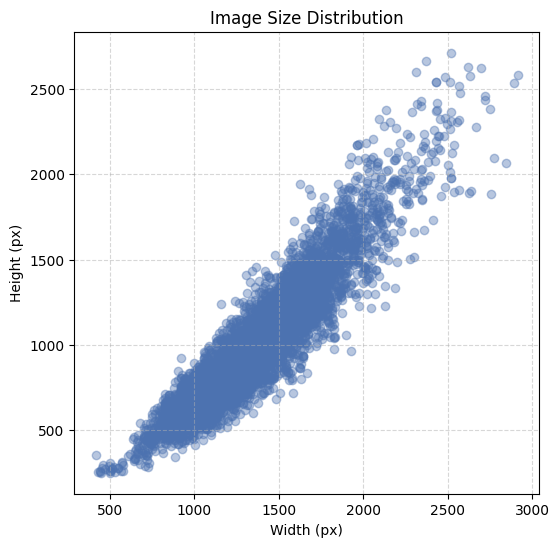

In [16]:
mode_size = df_all.groupby(["width", "height"]).size().reset_index(name="count").sort_values("count", ascending=False)
print("Most common image sizes:")
# display(mode_size.head())

print("Distribution ‡πÇ‡∏î‡∏¢‡∏£‡∏ß‡∏°")
plt.figure(figsize=(6,6))
plt.scatter(df_all["width"], df_all["height"], alpha=0.4, color="#4C72B0")
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.title("Image Size Distribution")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


‡∏à‡∏≤‡∏Å‡∏Å‡∏£‡∏≤‡∏ü‡∏à‡∏∞‡πÄ‡∏´‡πá‡∏ô‡πÑ‡∏î‡πâ‡∏ß‡πà‡∏≤ Width, Height ‡∏ó‡∏µ‡πà‡∏ä‡πà‡∏ß‡∏á 0 - 500 ‡∏°‡∏µ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÄ‡∏Å‡∏≤‡∏∞‡∏Å‡∏•‡∏∏‡πà‡∏°‡∏Å‡∏±‡∏ô‡∏à‡∏∂‡∏á‡∏ó‡∏≥‡∏Å‡∏≤‡∏£‡∏™‡∏≥‡∏£‡∏ß‡∏à‡πÄ‡∏û‡∏¥‡πà‡∏°‡πÄ‡∏ï‡∏¥‡∏°‡∏ß‡πà‡∏≤ ‡∏†‡∏≤‡∏û‡∏ó‡∏µ‡πà‡∏°‡∏µ‡∏Ñ‡∏ß‡∏≤‡∏°‡∏™‡∏π‡∏á‡∏Ñ‡∏ß‡∏≤‡∏°‡∏Å‡∏ß‡πâ‡∏≤‡∏á‡∏ó‡∏µ‡πà‡∏ô‡πâ‡∏≠‡∏¢‡∏°‡∏µ‡∏†‡∏≤‡∏û‡πÄ‡∏õ‡πá‡∏ô‡∏≠‡∏¢‡πà‡∏≤‡∏á‡πÑ‡∏£

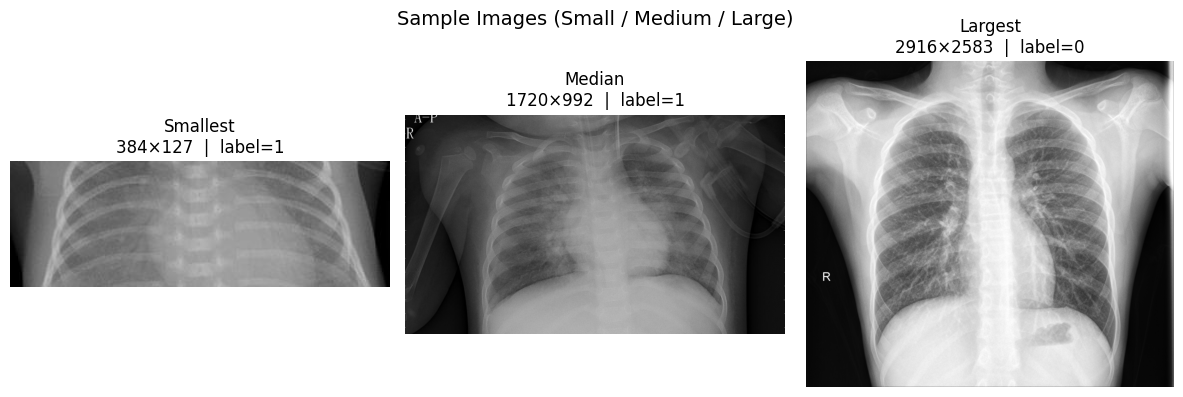

In [7]:
smallest = df_all.sort_values(by=["width", "height"]).iloc[0]
median = df_all.iloc[len(df_all)//2]
largest = df_all.sort_values(by=["width", "height"], ascending=False).iloc[0]

samples = [("Smallest", smallest), ("Median", median), ("Largest", largest)]

plt.figure(figsize=(12,4))

for i, (title, row) in enumerate(samples):
    plt.subplot(1, 3, i+1)
    img = Image.open(row["filepath"])
    plt.imshow(img, cmap='gray')
    plt.title(f"{title}\n{row['width']}√ó{row['height']}  |  label={row['label']}")
    plt.axis("off")

plt.suptitle("Sample Images (Small / Medium / Large)", fontsize=14)
plt.tight_layout()
plt.show()

‡∏û‡∏ö‡∏†‡∏≤‡∏û‡∏ó‡∏µ‡πà‡∏Ñ‡∏ß‡∏≤‡∏°‡∏™‡∏π‡∏á < 300 px ‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î 76 ‡∏†‡∏≤‡∏û


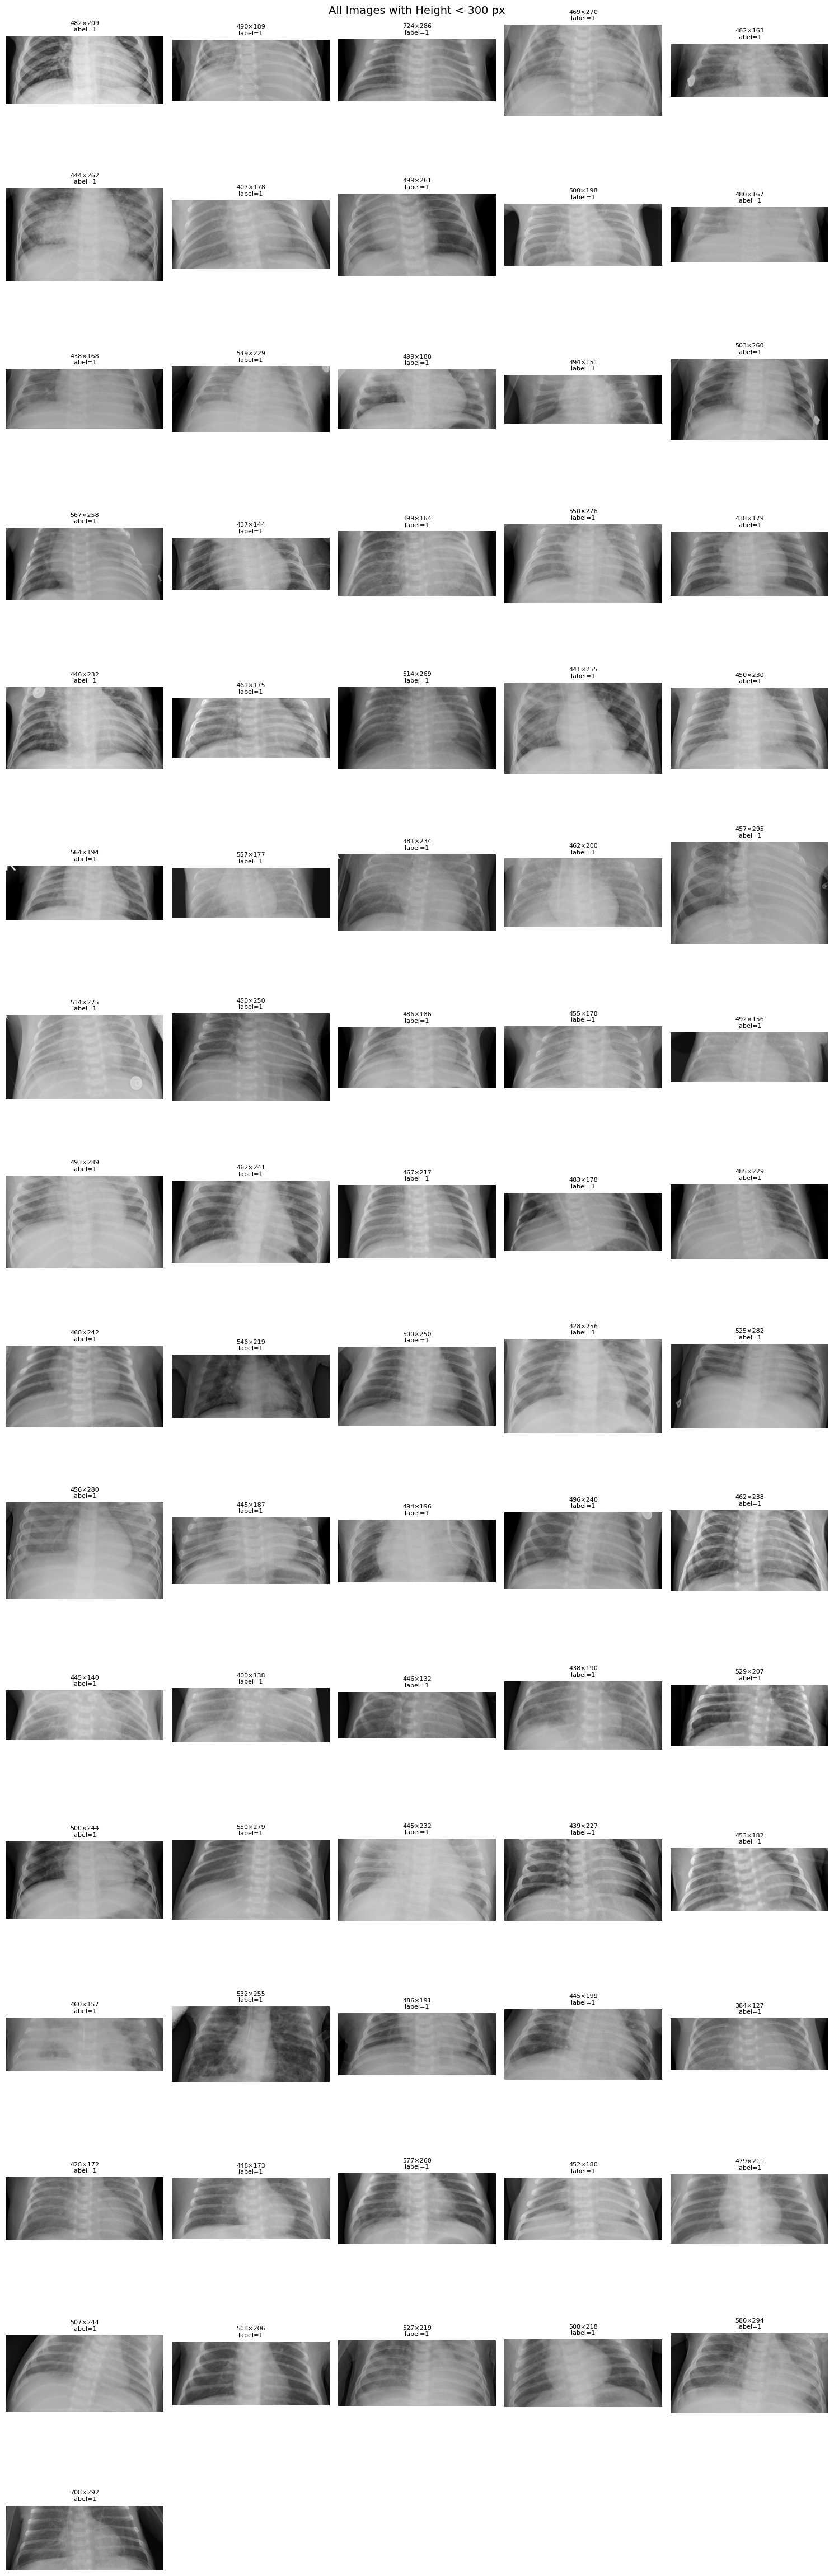

In [8]:
small_imgs = df_all[df_all["height"] < 300]

print(f"‡∏û‡∏ö‡∏†‡∏≤‡∏û‡∏ó‡∏µ‡πà‡∏Ñ‡∏ß‡∏≤‡∏°‡∏™‡∏π‡∏á < 300 px ‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î {len(small_imgs)} ‡∏†‡∏≤‡∏û")
n = len(small_imgs)
cols = 5
rows = (n // cols) + 1

plt.figure(figsize=(15, 3 * rows))
for i, (_, row) in enumerate(small_imgs.iterrows()):
    plt.subplot(rows, cols, i+1)
    try:
        img = Image.open(row["filepath"])
        plt.imshow(img, cmap="gray")
        plt.title(f"{row['width']}√ó{row['height']}\nlabel={row['label']}", fontsize=8)
        plt.axis("off")
    except Exception as e:
        plt.text(0.5, 0.5, "Error", ha="center", va="center")
        plt.axis("off")

plt.suptitle("All Images with Height < 300 px", fontsize=14)
plt.tight_layout()
plt.show()


‡πÇ‡∏î‡∏¢‡∏™‡∏£‡∏∏‡∏õ image sizes ‡∏°‡∏µ‡∏†‡∏≤‡∏û‡∏ó‡∏µ‡πà‡∏°‡∏µ‡∏Å‡∏≤‡∏£ crop ‡∏°‡∏≤‡∏ã‡∏∂‡πà‡∏á‡∏à‡∏∞‡πÄ‡∏õ‡πá‡∏ô‡∏†‡∏≤‡∏û‡∏ó‡∏µ‡πà‡∏°‡∏µ‡∏Ñ‡∏ß‡∏≤‡∏°‡∏™‡∏π‡∏á‡∏ô‡πâ‡∏≠‡∏¢‡∏Å‡∏ß‡πà‡∏≤ < 300 px ‡∏ã‡∏∂‡πà‡∏á‡∏à‡∏∞‡πÄ‡∏´‡πá‡∏ô‡πÅ‡∏Ñ‡πà‡πÉ‡∏ô‡∏™‡πà‡∏ß‡∏ô‡∏ä‡πà‡∏ß‡∏á‡∏≠‡∏Å ‡πÅ‡∏•‡∏∞‡∏™‡πà‡∏ß‡∏ô‡∏≠‡∏∑‡πà‡∏ô‡πÑ‡∏°‡πà‡πÄ‡∏´‡πá‡∏ô‡∏î‡∏±‡∏á‡∏ô‡∏±‡πâ‡∏ô‡∏à‡∏∂‡∏á‡∏à‡∏∞‡∏ó‡∏≥‡∏Å‡∏≤‡∏£‡∏ï‡∏±‡∏î‡∏≠‡∏≠‡∏Å‡πÄ‡∏û‡∏∑‡πà‡∏≠‡πÉ‡∏´‡πâ‡πÇ‡∏°‡πÄ‡∏î‡∏•‡πÑ‡∏°‡πà‡∏™‡∏±‡∏ö‡∏™‡∏ô‡πÅ‡∏•‡∏∞‡∏°‡∏≠‡∏á‡∏ß‡πà‡∏≤‡πÄ‡∏õ‡πá‡∏ô‡∏†‡∏≤‡∏û‡∏ó‡∏µ‡πà‡∏ñ‡∏π‡∏Å crop ‡∏°‡∏≤‡∏ñ‡∏∂‡∏á‡∏à‡∏∞‡πÄ‡∏´‡πá‡∏ô‡∏ä‡πà‡∏ß‡∏á‡∏≠‡∏Å‡πÅ‡∏ï‡πà‡∏ö‡∏≤‡∏á‡∏†‡∏≤‡∏û‡∏Å‡πá‡πÄ‡∏´‡πá‡∏ô‡∏≠‡∏á‡∏Ñ‡πå‡∏õ‡∏£‡∏∞‡∏Å‡∏≠‡∏ö‡∏£‡πà‡∏≤‡∏á‡∏Å‡∏≤‡∏¢‡πÑ‡∏°‡πà‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î ‡∏ö‡∏≤‡∏á‡∏ó‡∏µ pattern ‡∏≠‡∏≤‡∏à‡∏à‡∏∞‡∏≠‡∏¢‡∏π‡πà‡∏ö‡∏£‡∏¥‡πÄ‡∏ß‡∏ì‡∏≠‡∏∑‡πà‡∏ô‡∏î‡πâ‡∏ß‡∏¢‡∏Å‡πá‡πÑ‡∏î‡πâ

## Delete crop images

In [17]:
df_train = df_all[df_all["filepath"].str.contains("train")]
df_val = df_all[df_all["filepath"].str.contains("val")]
df_test = df_all[df_all["filepath"].str.contains("test")]

In [18]:
bad_images = df_all[df_all["height"] < 250]["filepath"]
print(f"‡∏û‡∏ö‡∏†‡∏≤‡∏û‡∏ó‡∏µ‡πà‡∏ï‡πâ‡∏≠‡∏á‡∏•‡∏ö‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î {len(bad_images)} ‡∏†‡∏≤‡∏û\n")

df_all = df_all[~df_all["filepath"].isin(bad_images)]
df_train = df_train[~df_train["filepath"].isin(bad_images)]
df_val   = df_val[~df_val["filepath"].isin(bad_images)]
df_test  = df_test[~df_test["filepath"].isin(bad_images)]

print("Updated dataset counts:")
print(f"All:   {len(df_all)}")
print(f"Train: {len(df_train)}")
print(f"Val:   {len(df_val)}")
print(f"Test:  {len(df_test)}")


‡∏û‡∏ö‡∏†‡∏≤‡∏û‡∏ó‡∏µ‡πà‡∏ï‡πâ‡∏≠‡∏á‡∏•‡∏ö‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î 0 ‡∏†‡∏≤‡∏û

Updated dataset counts:
All:   5802
Train: 5162
Val:   16
Test:  624


**3) check channel of images**

‡∏ó‡∏≥‡∏Å‡∏≤‡∏£‡πÄ‡∏ä‡πá‡∏Ñ‡∏ß‡πà‡∏≤‡∏†‡∏≤‡∏û‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î‡∏à‡∏≤‡∏Å Dataset ‡∏°‡∏µ‡∏†‡∏≤‡∏û‡∏ó‡∏µ‡πà‡πÄ‡∏õ‡πá‡∏ô Grayscale ‡πÅ‡∏•‡∏∞ RGB ‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡πÄ‡∏ó‡πà‡∏≤‡πÑ‡∏´‡∏£‡πà

In [19]:
modes = []
for path in tqdm(df_all["filepath"], desc="Checking image color mode"):
    try:
        with Image.open(path) as img:
            modes.append(img.mode)
    except:
        modes.append(None)

df_all["mode"] = modes


print("Image Mode Summary:")
display(df_all["mode"].value_counts())


Checking image color mode: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5802/5802 [00:01<00:00, 3242.61it/s]

Image Mode Summary:


mode
L      5573
RGB     229
Name: count, dtype: int64

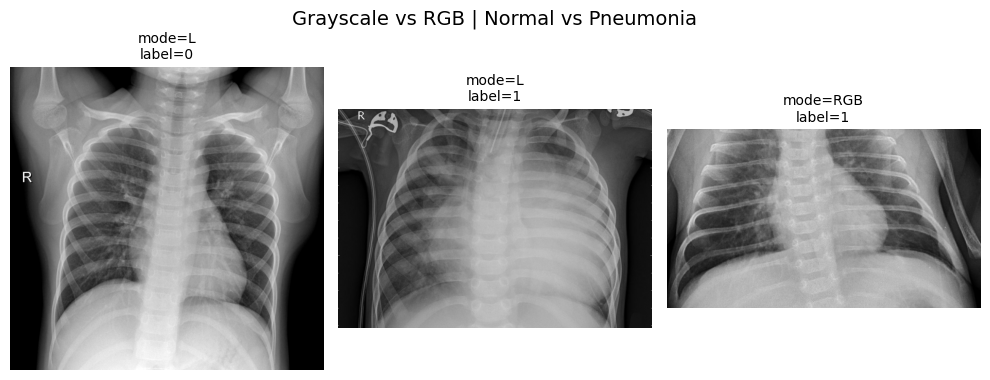

In [24]:
gray_normal     = df_all[(df_all["mode"] == "L")   & (df_all["label"] == 0)]
gray_pneumonia  = df_all[(df_all["mode"] == "L")   & (df_all["label"] == 1)]
rgb_normal      = df_all[(df_all["mode"] == "RGB") & (df_all["label"] == 0)]
rgb_pneumonia   = df_all[(df_all["mode"] == "RGB") & (df_all["label"] == 1)]

samples = pd.concat([
    gray_normal.sample(min(1, len(gray_normal)), random_state=123),
    gray_pneumonia.sample(min(1, len(gray_pneumonia)), random_state=4236),
    rgb_normal.sample(min(1, len(rgb_normal)), random_state=23412),
    rgb_pneumonia.sample(min(1, len(rgb_pneumonia)), random_state=222122),
])

plt.figure(figsize=(10, 4))
for i, (_, row) in enumerate(samples.iterrows()):
    img = Image.open(row["filepath"])
    plt.subplot(1, 3, i+1)
    plt.imshow(img, cmap="gray" if row["mode"] == "L" else None)
    plt.title(f"mode={row['mode']}\nlabel={row['label']}", fontsize=10)
    plt.axis("off")

plt.suptitle("Grayscale vs RGB | Normal vs Pneumonia", fontsize=14)
plt.tight_layout()
plt.show()


‡∏à‡∏≤‡∏Å‡∏†‡∏≤‡∏û‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î ‡∏°‡∏µ    
Grayscale     5573  
RGB           229   
‡πÅ‡∏•‡∏∞‡∏†‡∏≤‡∏û RGB ‡πÅ‡∏•‡∏∞‡∏†‡∏≤‡∏û Grayscale ‡∏Å‡πá‡∏°‡∏µ‡∏Ñ‡∏ß‡∏≤‡∏°‡∏ï‡πà‡∏≤‡∏á‡∏Å‡∏±‡∏ô‡πÑ‡∏°‡πà‡∏°‡∏≤‡∏Å‡πÅ‡∏•‡∏∞‡∏†‡∏≤‡∏û‡∏à‡∏∞‡∏ñ‡∏π‡∏Å crop ‡∏°‡∏≤‡πÄ‡∏•‡πá‡∏Å‡∏ô‡πâ‡∏≠‡∏¢ ‡∏ã‡∏∂‡πà‡∏á‡∏ñ‡πâ‡∏≤‡πÄ‡∏õ‡πá‡∏ô‡∏†‡∏≤‡∏û‡∏ó‡∏µ‡πà‡πÄ‡∏õ‡πá‡∏ô RGB ‡∏à‡∏∞‡πÑ‡∏°‡πà‡∏°‡∏µ Normal ‡∏†‡∏≤‡∏û‡∏ó‡∏µ‡πà‡πÄ‡∏õ‡πá‡∏ô RGB ‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î‡∏à‡∏∞‡πÄ‡∏õ‡πá‡∏ô‡πÇ‡∏£‡∏Ñ‡∏õ‡∏≠‡∏î‡∏≠‡∏±‡∏Å‡πÄ‡∏™‡∏ö  
‡∏î‡∏±‡∏á‡∏ô‡∏±‡πâ‡∏ô‡∏à‡∏∞‡∏ó‡∏≥‡∏Å‡∏≤‡∏£‡πÅ‡∏õ‡∏•‡∏á‡πÄ‡∏õ‡πá‡∏ô RGB ‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î‡πÄ‡∏ô‡∏∑‡πà‡∏≠‡∏á‡∏à‡∏≤‡∏Å ‡πÄ‡∏õ‡πâ‡∏≤‡∏´‡∏°‡∏≤‡∏¢‡πÉ‡∏ô‡∏Å‡∏≤‡∏£‡πÄ‡∏•‡∏∑‡∏≠‡∏Å model ‡∏°‡∏≤ train ‡∏à‡∏∞‡πÄ‡∏õ‡πá‡∏ô Transfer learning ‡πÄ‡∏ä‡πà‡∏ô Resnet ViT ‡∏ã‡∏∂‡πà‡∏á‡∏à‡∏∞‡∏£‡∏≠‡∏á‡∏£‡∏±‡∏ö‡πÄ‡∏â‡∏û‡∏≤‡∏∞ RGB ‡πÄ‡∏ó‡πà‡∏≤‡∏ô‡∏±‡πâ‡∏ô‡πÅ‡∏•‡∏∞‡∏ñ‡∏∂‡∏á‡∏à‡∏∞‡πÄ‡∏õ‡πá‡∏ô‡πÄ‡∏õ‡πá‡∏ô RGB ‡∏†‡∏≤‡∏û‡πÄ‡∏î‡∏¥‡∏°‡∏ó‡∏µ‡πà‡πÄ‡∏õ‡πá‡∏ô Grayscale ‡∏Å‡πá‡∏¢‡∏±‡∏á‡∏Ñ‡∏á‡πÄ‡∏î‡∏¥‡∏°‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÑ‡∏°‡πà‡πÄ‡∏õ‡∏•‡∏µ‡πà‡∏¢‡∏ô‡πÅ‡∏õ‡∏•‡∏á

## Convert all image to RGB

# ‡∏£‡∏±‡∏ô‡∏Ñ‡∏£‡∏±‡πâ‡∏á‡πÄ‡∏î‡∏µ‡∏¢‡∏ß ‡πÅ‡∏•‡πâ‡∏ß comment ‡πÑ‡∏ß‡πâ

In [ ]:
# new_dir = "Data/chest_xray_new"
# os.makedirs(new_dir, exist_ok=True)

# all_paths = pd.concat([df_all, df_train, df_val, df_test])["filepath"].unique()

# print(f"‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏†‡∏≤‡∏û RGB ‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î {len(all_paths)} ‡πÑ‡∏ü‡∏•‡πå ‡πÑ‡∏õ‡∏¢‡∏±‡∏á: {new_dir}")

# for path in tqdm(all_paths, desc="Converting to RGB (new folder)"):
#     try:
#         rel_name = os.path.basename(path)
#         dst_path = os.path.join(new_dir, rel_name)

#         with Image.open(path) as img:
#             rgb_img = img.convert("RGB")
#             rgb_img.save(dst_path)
#     except Exception as e:
#         print(f"‚ö†Ô∏è Error converting {path}: {e}")

# print("‡πÅ‡∏õ‡∏•‡∏á‡∏†‡∏≤‡∏û‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î‡πÄ‡∏õ‡πá‡∏ô RGB ‡πÅ‡∏•‡∏∞‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡πÉ‡∏ô Data/chest_xray_new ‡πÄ‡∏£‡∏µ‡∏¢‡∏ö‡∏£‡πâ‡∏≠‡∏¢‡πÅ‡∏•‡πâ‡∏ß")


‡∏Å‡∏≥‡∏•‡∏±‡∏á‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏†‡∏≤‡∏û RGB ‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î 5802 ‡πÑ‡∏ü‡∏•‡πå ‡πÑ‡∏õ‡∏¢‡∏±‡∏á: Data/chest_xray_new


Converting to RGB (new folder):   0%|          | 0/5802 [00:00<?, ?it/s]

Converting to RGB (new folder): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5802/5802 [04:02<00:00, 23.89it/s]


‚úÖ ‡πÅ‡∏õ‡∏•‡∏á‡∏†‡∏≤‡∏û‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î‡πÄ‡∏õ‡πá‡∏ô RGB ‡πÅ‡∏•‡∏∞‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡πÉ‡∏ô Data/chest_xray_new ‡πÄ‡∏£‡∏µ‡∏¢‡∏ö‡∏£‡πâ‡∏≠‡∏¢‡πÅ‡∏•‡πâ‡∏ß
‚úÖ ‡∏≠‡∏±‡∏õ‡πÄ‡∏î‡∏ï path ‡πÉ‡∏ô df_all, df_train, df_val, df_test ‡πÄ‡∏£‡∏µ‡∏¢‡∏ö‡∏£‡πâ‡∏≠‡∏¢‡πÅ‡∏•‡πâ‡∏ß

üìÅ ‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á path ‡∏´‡∏•‡∏±‡∏á‡∏≠‡∏±‡∏õ‡πÄ‡∏î‡∏ï:
0    Data/chest_xray_new\IM-0115-0001.jpeg
1    Data/chest_xray_new\IM-0117-0001.jpeg
2    Data/chest_xray_new\IM-0119-0001.jpeg
3    Data/chest_xray_new\IM-0122-0001.jpeg
4    Data/chest_xray_new\IM-0125-0001.jpeg
Name: filepath, dtype: object

üìä ‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡πÑ‡∏ü‡∏•‡πå:
df_all_new  : 5802
df_train_new: 5162
df_val_new  : 16
df_test_new : 624


In [52]:
def update_paths(df, new_dir):
    df = df.copy()
    df["filepath"] = df["filepath"].apply(lambda x: os.path.join(new_dir, os.path.basename(x)))
    return df

df_all_new  = update_paths(df_all, "Data/chest_xray_new")
df_train_new = update_paths(df_train, "Data/chest_xray_new")
df_val_new   = update_paths(df_val, "Data/chest_xray_new")
df_test_new  = update_paths(df_test, "Data/chest_xray_new")


df_train_new = df_train_new[~df_train_new["filepath"].str.endswith(".DS_Store")].reset_index(drop=True)
df_val_new   = df_val_new[~df_val_new["filepath"].str.endswith(".DS_Store")].reset_index(drop=True)
df_test_new  = df_test_new[~df_test_new["filepath"].str.endswith(".DS_Store")].reset_index(drop=True)

print("path ‡πÉ‡∏ô df_all, df_train, df_val, df_test")

print("‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡πÑ‡∏ü‡∏•‡πå:")
print(f"df_all_new  : {len(df_all_new)}")
print(f"df_train_new: {len(df_train_new)}")
print(f"df_val_new  : {len(df_val_new)}")
print(f"df_test_new : {len(df_test_new)}")

path ‡πÉ‡∏ô df_all, df_train, df_val, df_test
‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡πÑ‡∏ü‡∏•‡πå:
df_all_new  : 5802
df_train_new: 5162
df_val_new  : 16
df_test_new : 624


‡πÇ‡∏î‡∏¢‡∏™‡∏£‡∏∏‡∏õ Data preparation
‡∏à‡∏≤‡∏Å‡∏†‡∏≤‡∏û‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î‡∏°‡∏µ 5856 ‡∏†‡∏≤‡∏û...

## Exploratory Data Analysis

**1) Histogram**

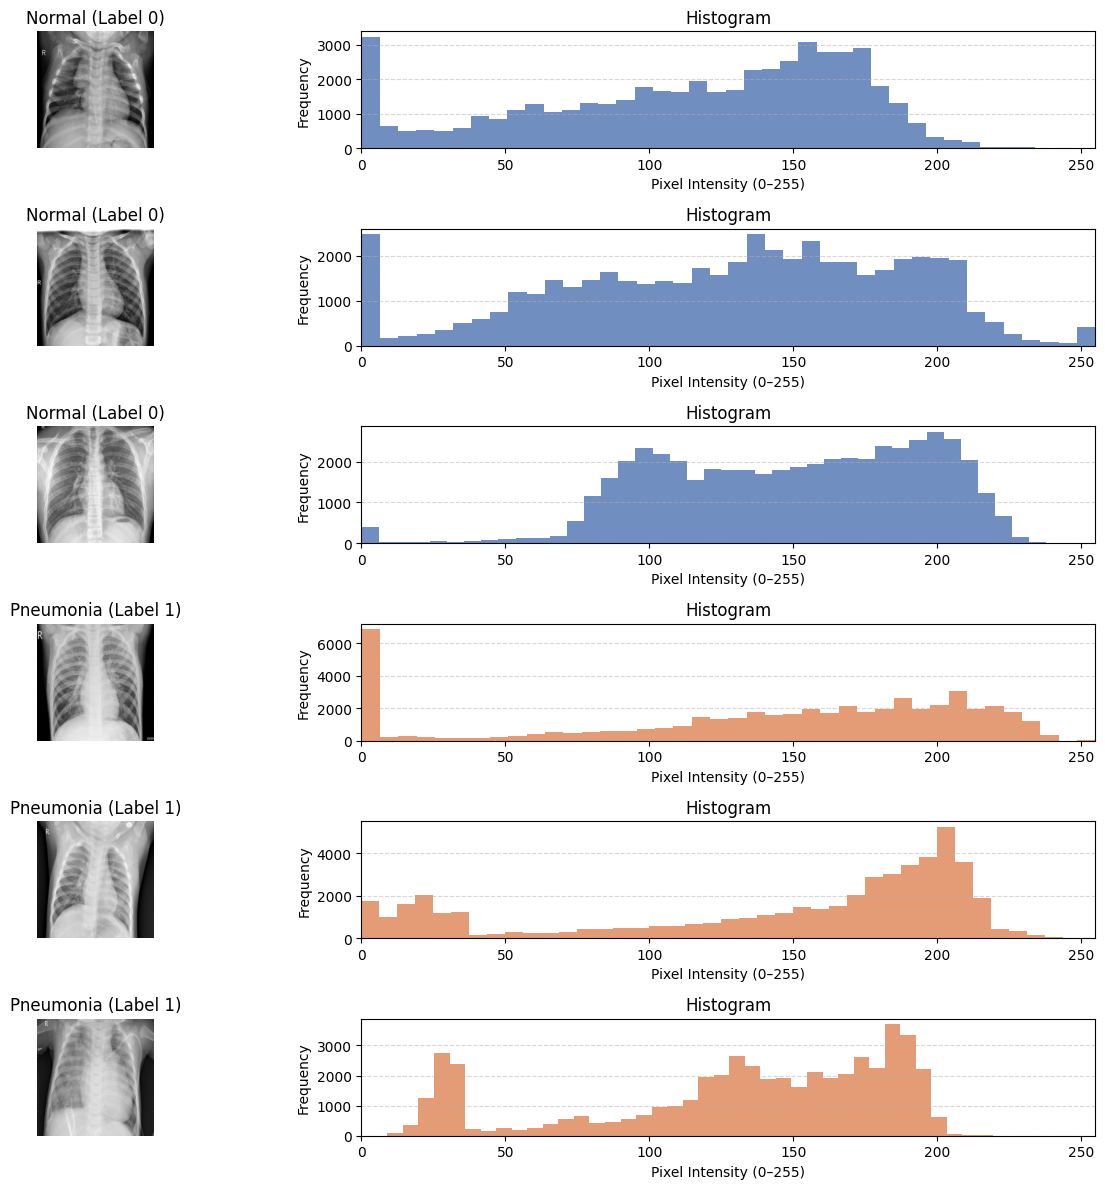

In [28]:
samples_0 = df_all_new[df_all_new["label"] == 0].sample(3, random_state=2343)
samples_1 = df_all_new[df_all_new["label"] == 1].sample(3, random_state=3343)

resize_size = (224, 224)
plt.figure(figsize=(14, 12))

def plot_image_and_hist(row, index, label_name, color):
    img = Image.open(row["filepath"]).convert("L").resize(resize_size)
    arr = np.array(img)

    # ‡∏†‡∏≤‡∏û‡∏à‡∏£‡∏¥‡∏á
    plt.subplot(6, 2, 2*index - 1)
    plt.imshow(arr, cmap="gray")
    plt.title(f"{label_name} (Label {row['label']})", fontsize=12)
    plt.axis("off")

    # histogram
    plt.subplot(6, 2, 2*index)
    plt.hist(arr.ravel(), bins=40, color=color, alpha=0.8)
    plt.xlim(0, 255)  
    plt.xlabel("Pixel Intensity (0‚Äì255)", fontsize=10)
    plt.ylabel("Frequency", fontsize=10)
    plt.title("Histogram", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.5)

for i, (_, row) in enumerate(samples_0.iterrows(), start=1):
    plot_image_and_hist(row, i, "Normal", "#4C72B0")

for i, (_, row) in enumerate(samples_1.iterrows(), start=4):
    plot_image_and_hist(row, i, "Pneumonia", "#DD8452")

plt.tight_layout()
plt.show()


‡∏à‡∏≤‡∏Å‡∏Å‡∏£‡∏≤‡∏ü‡∏à‡∏∞‡πÄ‡∏´‡πá‡∏ô‡∏ß‡πà‡∏≤ ‡∏†‡∏≤‡∏û‡∏ó‡∏µ‡πà‡∏õ‡πà‡∏ß‡∏¢‡πÄ‡∏õ‡πá‡∏ô‡∏õ‡∏≠‡∏î‡∏≠‡∏±‡∏Å‡πÄ‡∏™‡∏ö Histogram ‡∏à‡∏∞‡∏°‡∏µ‡∏Ñ‡∏ß‡∏≤‡∏°‡πÄ‡∏ö‡πâ‡∏ã‡πâ‡∏≤‡∏¢‡∏Ñ‡∏∑‡∏≠ pixel ‡∏™‡πà‡∏ß‡∏ô‡∏°‡∏≤‡∏Å‡∏à‡∏∞‡πÄ‡∏≠‡∏ô‡πÄ‡∏≠‡∏µ‡πà‡∏¢‡∏á‡πÑ‡∏õ‡∏ó‡∏≤‡∏á‡∏ä‡πà‡∏ß‡∏á 200 ‡πÄ‡∏¢‡∏≠‡∏∞‡πÅ‡∏™‡∏î‡∏á‡∏ñ‡∏∂‡∏á‡∏°‡∏µ‡∏™‡∏µ‡∏Ç‡∏≤‡∏ß‡πÄ‡∏¢‡∏≠‡∏∞

**2) Class distribution**

Class Distribution by Dataset


label     0     1  Total  % Normal (0)  % Pneumonia (1)
All    1583  4219   5802          27.3             72.7
Train  1341  3821   5162          26.0             74.0
Val       8     8     16          50.0             50.0
Test    234   390    624          37.5             62.5

<Figure size 800x500 with 0 Axes>

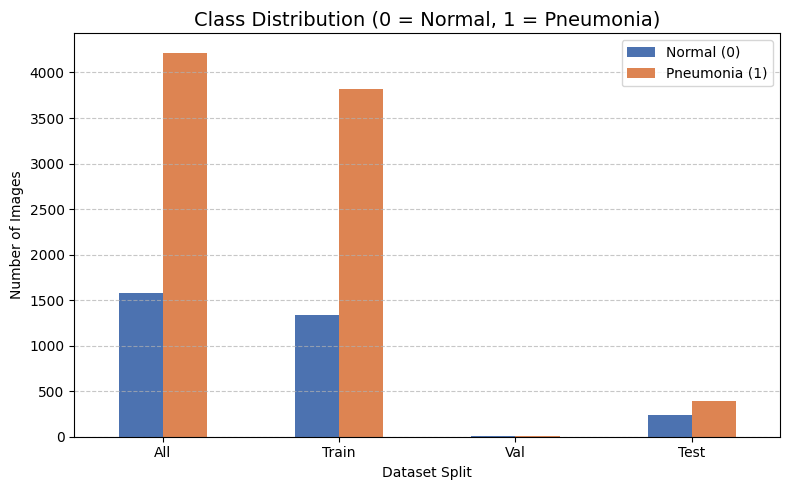

In [29]:
counts_train = df_train_new['label'].value_counts().sort_index()
counts_val = df_val_new['label'].value_counts().sort_index()
counts_test = df_test_new['label'].value_counts().sort_index()
counts_all = df_all_new['label'].value_counts().sort_index()

df_summary = pd.DataFrame({
    'All': counts_all,
    'Train': counts_train,
    'Val': counts_val,
    'Test': counts_test,

}).T.fillna(0).astype(int)

df_summary['Total'] = df_summary[0] + df_summary[1]
df_summary['% Normal (0)'] = (df_summary[0] / df_summary['Total'] * 100).round(1)
df_summary['% Pneumonia (1)'] = (df_summary[1] / df_summary['Total'] * 100).round(1)

print("Class Distribution by Dataset")
display(df_summary)

plt.figure(figsize=(8,5))
df_summary[[0,1]].plot(
    kind='bar',
    stacked=False,
    color=['#4C72B0', '#DD8452'],
    figsize=(8,5)
)
plt.title('Class Distribution (0 = Normal, 1 = Pneumonia)', fontsize=14)
plt.xlabel('Dataset Split')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.legend(['Normal (0)', 'Pneumonia (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Data splitting

In [53]:
df_val_old = df_val_new.copy()
df_test_old = df_test_new.copy()
df_train_old = df_train_new.copy()

print("Train:", len(df_train_old))
print("Test:", len(df_test_old))
print("Val:", len(df_val_old))

Train: 5162
Test: 624
Val: 16


In [54]:
target_val = 870
target_test = 870

In [55]:
used_paths = set(df_val_old['filepath']).union(df_test_old['filepath'])
df_remaining = df_train_new[~df_train_new['filepath'].isin(used_paths)]

In [56]:
need_val = target_val - len(df_val_old)
need_test = target_test - len(df_test_old)
need_more = need_val + need_test
print(f"‡∏ï‡πâ‡∏≠‡∏á‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î {need_more} ‡∏£‡∏π‡∏õ (val {need_val}, test {need_test})")

‡∏ï‡πâ‡∏≠‡∏á‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î 1100 ‡∏£‡∏π‡∏õ (val 854, test 246)


In [62]:
df_extra, df_train_new = train_test_split(
    df_remaining,
    test_size=(len(df_remaining) - need_more) / len(df_remaining),
    stratify=df_remaining["label"],
    random_state=42
)


df_val_add = df_extra.sample(n=need_val, random_state=42)
df_test_add = df_extra.drop(df_val_add.index).sample(n=need_test, random_state=42)

df_val_new = pd.concat([df_val_old, df_val_add], ignore_index=True)
df_test_new = pd.concat([df_test_old, df_test_add], ignore_index=True)

In [ ]:
print("Train:", len(df_train_new))
print("Val:", len(df_val_new))
print("Test:", len(df_test_new))
print("‡∏£‡∏ß‡∏°‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î:", len(df_train_new) + len(df_val_new) + len(df_test_new))

#‡πÄ‡∏ä‡πá‡∏Å‡∏ß‡πà‡∏≤‡πÑ‡∏°‡πà‡∏°‡∏µ filepath ‡∏ã‡πâ‡∏≥‡∏Å‡∏±‡∏ô‡∏£‡∏∞‡∏´‡∏ß‡πà‡∏≤‡∏á‡πÄ‡∏ã‡πá‡∏ï
assert len(set(df_val_new['filepath']).intersection(df_test_new['filepath'])) == 0, "‚ö†Ô∏è ‡∏°‡∏µ filepath ‡∏ã‡πâ‡∏≥‡∏£‡∏∞‡∏´‡∏ß‡πà‡∏≤‡∏á val/test!"
assert len(set(df_val_new['filepath']).intersection(df_train_new['filepath'])) == 0, "‚ö†Ô∏è ‡∏°‡∏µ filepath ‡∏ã‡πâ‡∏≥‡∏£‡∏∞‡∏´‡∏ß‡πà‡∏≤‡∏á val/train!"
assert len(set(df_test_new['filepath']).intersection(df_train_new['filepath'])) == 0, "‚ö†Ô∏è ‡∏°‡∏µ filepath ‡∏ã‡πâ‡∏≥‡∏£‡∏∞‡∏´‡∏ß‡πà‡∏≤‡∏á test/train!"

Train: 4062
Val: 870
Test: 870
‡∏£‡∏ß‡∏°‡∏ó‡∏±‡πâ‡∏á‡∏´‡∏°‡∏î: 5802


Class Distribution by Dataset


label     0     1  Total  % Normal (0)  % Pneumonia (1)
All    1583  4219   5802          27.3             72.7
Train  1055  3007   4062          26.0             74.0
Val     221   649    870          25.4             74.6
Test    307   563    870          35.3             64.7

<Figure size 800x500 with 0 Axes>

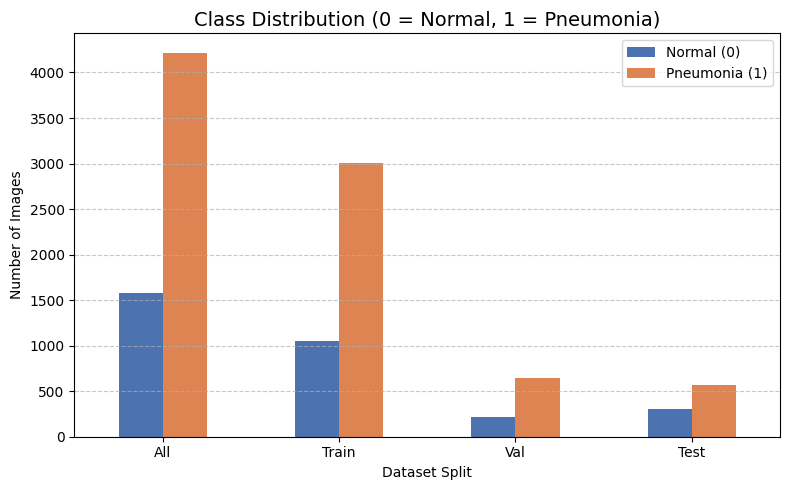

In [66]:
counts_train = df_train_new['label'].value_counts().sort_index()
counts_val = df_val_new['label'].value_counts().sort_index()
counts_test = df_test_new['label'].value_counts().sort_index()
counts_all = df_all_new['label'].value_counts().sort_index()

df_summary = pd.DataFrame({
    'All': counts_all,
    'Train': counts_train,
    'Val': counts_val,
    'Test': counts_test,

}).T.fillna(0).astype(int)

df_summary['Total'] = df_summary[0] + df_summary[1]
df_summary['% Normal (0)'] = (df_summary[0] / df_summary['Total'] * 100).round(1)
df_summary['% Pneumonia (1)'] = (df_summary[1] / df_summary['Total'] * 100).round(1)

print("Class Distribution by Dataset")
display(df_summary)

plt.figure(figsize=(8,5))
df_summary[[0,1]].plot(
    kind='bar',
    stacked=False,
    color=['#4C72B0', '#DD8452'],
    figsize=(8,5)
)
plt.title('Class Distribution (0 = Normal, 1 = Pneumonia)', fontsize=14)
plt.xlabel('Dataset Split')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.legend(['Normal (0)', 'Pneumonia (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Transforms

In [67]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# (A) RGB -------------------------------------------------------------------------
train_transform_rgb_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(12),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

train_transform_rgb_noaug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

val_test_transform_rgb = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# (B) Grayscale -------------------------------------------------------------------
train_transform_gray_aug = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(12),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_transform_gray_noaug = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transform_gray = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])



In [68]:
class XrayDataset(Dataset):
    def __init__(self, df, transform=None):
        self.filepaths = df["filepath"].values
        self.labels = df["label"].values
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        label = torch.tensor(self.labels[idx]).long()
        with Image.open(img_path) as img:
            if self.transform:
                img = self.transform(img)
        return img, label


def balance_dataset_keep_original(df, target_0=3200, target_1=3500):
    df0 = df[df["label"] == 0]
    df1 = df[df["label"] == 1]

    n0, n1 = len(df0), len(df1)
    print(f"Before: class0={n0}, class1={n1} ‚Üí total={len(df)}")

    add0 = max(target_0 - n0, 0)
    add1 = max(target_1 - n1, 0)

    df0_aug = df0.sample(add0, replace=True, random_state=42) if add0 > 0 else pd.DataFrame(columns=df.columns)
    df1_aug = df1.sample(add1, replace=True, random_state=42) if add1 > 0 else pd.DataFrame(columns=df.columns)

    df0_final = pd.concat([df0, df0_aug])
    df1_final = pd.concat([df1, df1_aug])

    df_balanced = pd.concat([df0_final, df1_final]).sample(frac=1, random_state=42).reset_index(drop=True)
    print(f"After : class0={len(df0_final)}, class1={len(df1_final)} ‚Üí total={len(df_balanced)}")

    return df_balanced



In [70]:
df_train_balanced = balance_dataset_keep_original(df_train_new, target_0=3200, target_1=3500)

# -------------------- RGB --------------------
train_ds_rgb_aug     = XrayDataset(df_train_balanced, transform=train_transform_rgb_aug)
train_ds_rgb_noaug   = XrayDataset(df_train_new, transform=train_transform_rgb_noaug)
val_ds_rgb           = XrayDataset(df_val_new, transform=val_test_transform_rgb)
test_ds_rgb          = XrayDataset(df_test_new, transform=val_test_transform_rgb)

# -------------------- Grayscale --------------------
train_ds_gray_aug    = XrayDataset(df_train_balanced, transform=train_transform_gray_aug)
train_ds_gray_noaug  = XrayDataset(df_train_new, transform=train_transform_gray_noaug)
val_ds_gray          = XrayDataset(df_val_new, transform=val_test_transform_gray)
test_ds_gray         = XrayDataset(df_test_new, transform=val_test_transform_gray)


Before: class0=1055, class1=3007 ‚Üí total=4062
After : class0=3200, class1=3500 ‚Üí total=6700


In [71]:
batch_size = 16

# --- RGB ---
train_loader_rgb_aug    = DataLoader(train_ds_rgb_aug, batch_size=batch_size, shuffle=True, num_workers=2)
train_loader_rgb_noaug  = DataLoader(train_ds_rgb_noaug, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader_rgb          = DataLoader(val_ds_rgb, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_rgb         = DataLoader(test_ds_rgb, batch_size=batch_size, shuffle=False, num_workers=2)

# --- Grayscale ---
train_loader_gray_aug   = DataLoader(train_ds_gray_aug, batch_size=batch_size, shuffle=True, num_workers=2)
train_loader_gray_noaug = DataLoader(train_ds_gray_noaug, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader_gray         = DataLoader(val_ds_gray, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_gray        = DataLoader(test_ds_gray, batch_size=batch_size, shuffle=False, num_workers=2)

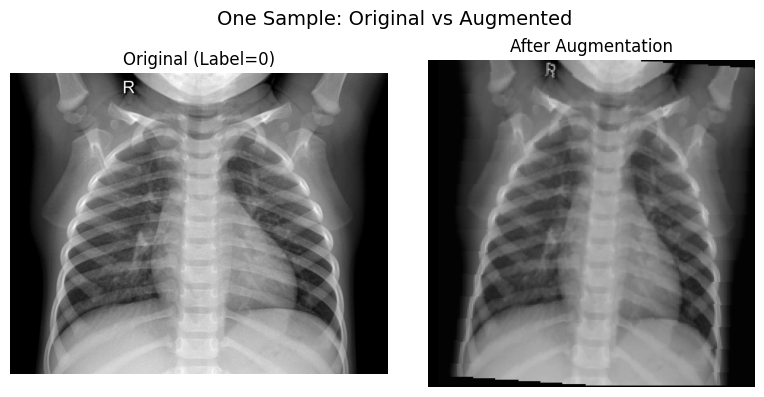

In [72]:
use_rgb = True  
sample = df_train_new.sample(3).iloc[0]
img_path = sample["filepath"]
label = sample["label"]

orig_img = Image.open(img_path)

if use_rgb:
    transform = train_transform_rgb_aug
    mean, std = imagenet_mean, imagenet_std
    orig_img_disp = orig_img.convert("RGB")
else:
    transform = train_transform_gray_aug
    mean, std = [0.5], [0.5]
    orig_img_disp = orig_img.convert("L")

aug_img_tensor = transform(orig_img)
aug_img = aug_img_tensor.clone()

for t, m, s in zip(aug_img, mean, std):
    t.mul_(s).add_(m)
aug_img = torch.clamp(aug_img, 0, 1)
aug_img = aug_img.permute(1, 2, 0).numpy()

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(orig_img_disp, cmap="gray" if not use_rgb else None)
plt.title(f"Original (Label={label})")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(aug_img.squeeze(), cmap="gray" if not use_rgb else None)
plt.title("After Augmentation")
plt.axis("off")

plt.suptitle("One Sample: Original vs Augmented", fontsize=14)
plt.tight_layout()
plt.show()


## Model training 